# Import

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import random
from random import randint


In [3]:
FILE_NAME = "PQ2MON - Orders - Weeks -1 to -109 (1).xls.xlsx"
DF = pd.read_excel(FILE_NAME)
DF.head(5)

,Client Grouping1,Customer Group,Requested Mode,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Lane ID - City to City,Start Date,Completion Date,Order #,Avg. Weekly Frequency
0,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-04-16,2019-04-18,3790088,0
1,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-05-07,2019-05-09,3810953,0
2,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-06-07,2019-06-10,3841144,0
3,Corporate,3M Canada Company,ROAD,Standard,DRY,ON2TOR,PQ2S,"MILTON,ON/ to DRUMMONDVILLE,PQ/",2019-07-09,2019-07-11,3869973,0
4,Corporate,3M Canada Company,ROAD,Standard,DRY,PQ2MON,USMWIA,"STE THERESE,PQ/TE to PRAIRIE DU CHIEN,WI/",2020-02-26,2020-03-02,4066936,0


In [4]:
DAYS_0 = pd.Timedelta(days=0)
DAYS_1 = pd.Timedelta(days=1)
DAYS_14 = pd.Timedelta(days=14)

# Helper Functions

## Clean Data

In [5]:
# Clean the irrelevant columns, only keeping the rows that has PQ data
# internal are orders that starts and completes within the PQ region itself.
# external are orders that goes from anyhwere in PQ to other region and vice versa
def get_df_clean(df,select=None,drop=["Customer Group","Requested Mode","Order #","Avg. Weekly Frequency","Lane ID - City to City","Client Grouping1"]):
    df_PQ = df[df['Shipper Region3'].str.contains('PQ')|df['Consignee Region3'].str.contains('PQ')].drop(columns=drop)
    df_PQ.loc[:,'Shipper Region3'].fillna("UNKNOWN",inplace=True)
    df_PQ.loc[:,'Consignee Region3'].fillna("UNKNOWN",inplace=True)
    df_PQ_int = df_PQ[df_PQ["Shipper Region3"].str.contains('PQ') & df_PQ["Consignee Region3"].str.contains('PQ')]
    df_PQ_ext = df_PQ.drop(index=df_PQ_int.index)
    if select == "internal": return df_PQ_int
    elif select == "external": return df_PQ_ext
    else: return df_PQ

In [6]:
# Demo
DF_CLEAN = get_df_clean(DF)
DF_CLEAN

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
0,Standard,DRY,ON2TOR,PQ2S,2019-04-16,2019-04-18
1,Standard,DRY,ON2TOR,PQ2S,2019-05-07,2019-05-09
2,Standard,DRY,ON2TOR,PQ2S,2019-06-07,2019-06-10
3,Standard,DRY,ON2TOR,PQ2S,2019-07-09,2019-07-11
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
...,...,...,...,...,...,...
23864,Standard,DRY,PQ2MON,BC2VAN,2020-06-18,2020-06-22
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20
23867,Standard,REEFER,PQ2MON,ABNEDM,2020-02-13,2020-02-18


In [7]:
df_PQ_ext = get_df_clean(DF,'external')
print(len(df_PQ_ext))
df_PQ_ext.head(5)

22364


,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
0,Standard,DRY,ON2TOR,PQ2S,2019-04-16,2019-04-18
1,Standard,DRY,ON2TOR,PQ2S,2019-05-07,2019-05-09
2,Standard,DRY,ON2TOR,PQ2S,2019-06-07,2019-06-10
3,Standard,DRY,ON2TOR,PQ2S,2019-07-09,2019-07-11
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02


In [8]:
df_PQ_int = get_df_clean(DF,'internal')
print(len(df_PQ_int))
df_PQ_int.head(5)

710


,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
11,Standard,DRY,PQ2OTT,PQ2MON,2019-10-25,2019-10-28
12,Standard,DRY,PQ2OTT,PQ2MON,2019-10-07,2019-10-09
13,Standard,DRY,PQ2OTT,PQ2MON,2019-11-08,2019-11-12
14,Standard,DRY,PQ2OTT,PQ2MON,2019-12-03,2019-12-03
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03


## Getting the statistics

In [80]:
# Get the counts for a schedule, such as inbound and out bound figures. Also calculates the imbalance levels
def get_df_count(df,start_date=None,end_date=None,fill_missing=False,region='PQ'):
    if start_date == None: start_date = get_earliest(df,'Start Date')
    if end_date == None: end_date = get_latest(df,'Completion Date')
    if region == 'any': region = ''
    df_out = df[df['Shipper Region3'].str.startswith(region)]['Start Date'].value_counts().sort_index(axis=0)
    df_in = df[df['Consignee Region3'].str.startswith(region)]['Completion Date'].value_counts().sort_index(axis=0)
    df_count = pd.concat([df_out, df_in],axis=1).fillna(0, downcast='infer').rename(columns={"Start Date": "Outbound", "Completion Date": "Inbound"})
    if fill_missing and start_date and end_date:
        df_count = pd.DataFrame(index=get_dates(start_date,end_date)).join(df_count,how='outer').fillna(0) 
    df_count = df_count[start_date:end_date]
    df_count["Imbalance"] = df_count["Inbound"] - df_count["Outbound"]
    df_count["cImbalance"] = df_count["Imbalance"].cumsum()
    return df_count.astype('int64')

# Get the imbalance level of the date
def get_imb(df,date,col="Imbalance"):
    if (col == "Imbalance" or col == "cImbalance") and date in df.index:
        return df.loc[date,col]
    
def get_dates(start_date,end_date):
    if type(start_date) == pd.Timestamp and type(end_date) == pd.Timestamp:
        return [start_date + i*DAYS_1 for i in range(int((end_date-start_date).days+1))]
    else: return []

def get_earliest(df,col=["Start Date","Completion Date"],region='PQ'):
    region = '' if region == 'any' else region
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].min().min()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].min()
    
def get_latest(df,col=["Start Date","Completion Date"],region='PQ'):
    region = '' if region == 'any' else region
    if col == ["Start Date","Completion Date"]:
        return df.loc[:,col].max().max()
    elif col == 'Start Date':
        cond = df['Shipper Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()
    elif col == 'Completion Date':
        cond = df['Consignee Region3'].str.startswith(region) 
        return df[cond].loc[:,col].max()
    
def compare_df_count(dfs,fill_missing=True):
    df_counts = [get_df_count(d,fill_missing=fill_missing) for d in dfs]
    return pd.concat(df_counts,axis=1).fillna(0).astype('int64')

In [88]:
# Get the counts for a schedule, such as inbound and out bound figures. Also calculates the imbalance levels
def get_df_count(df,tr_class=None,start_date=None,end_date=None,fill_missing=False,region='PQ'):
    if tr_class == None: cond_tr_class = True
    else: cond_tr_class = df['Requested Trailer Class'] == tr_class
 
    if start_date == None: 
        start_date = get_earliest(df,'Start Date')
    if end_date == None: 
        end_date = get_latest(df,'Completion Date')
    if fill_missing and start_date and end_date:
        df_count = pd.DataFrame(index=get_dates(start_date,end_date))
    else: df_count = pd.DataFrame()
    if region == None: 
        region = ''
        
    df_out = df[df['Shipper Region3'].str.startswith(region) & cond_tr_class]['Start Date'].value_counts().sort_index(axis=0)
    df_in = df[df['Consignee Region3'].str.startswith(region) & cond_tr_class]['Completion Date'].value_counts().sort_index(axis=0)
    df_count = pd.concat([df_out, df_in],axis=1).fillna(0, downcast='infer').rename(columns={"Start Date": "Outbound", "Completion Date": "Inbound"})
    df_count["Imbalance"] = df_count["Inbound"] - df_count["Outbound"]
    df_count["cImbalance"] = df_count["Imbalance"].cumsum()
    df_count = df_count.loc[start_date:end_date]
    return df_count.astype('int64')

In [89]:
# HEATER, REEFER, M-REEFER can be counted as DRY as well
# Balance these orders first. DRY will be balanced last (may be / may be not?)

In [94]:
get_df_count(df,'M-REEFER')

,Outbound,Inbound,Imbalance,cImbalance
2019-05-15,0,1,1,1
2019-05-21,0,1,1,2
2020-03-12,0,1,1,3
2020-06-10,1,0,-1,2
2020-12-08,0,1,1,3
2020-12-15,0,1,1,4
2020-12-23,0,1,1,5
2020-12-29,0,1,1,6
2021-01-06,0,1,1,7
2021-01-13,0,1,1,8


In [47]:
df = DF_CLEAN
df1 = get_df_count(df)
df2 = get_df_count(df)[1:-1]
df2
df1.join(df2,how='outer',lsuffix="l_",rsuffix="r_").fillna(0).astype('int64')

,Outboundl_,Inboundl_,Imbalancel_,cImbalancel_,Outboundr_,Inboundr_,Imbalancer_,cImbalancer_
2019-03-13,1,0,-1,-1,0,0,0,0
2019-03-19,2,0,-2,-3,2,0,-2,-3
2019-03-20,2,0,-2,-5,2,0,-2,-5
2019-03-21,1,0,-1,-6,1,0,-1,-6
2019-03-22,12,0,-12,-18,12,0,-12,-18
...,...,...,...,...,...,...,...,...
2021-04-20,21,20,-1,251,21,20,-1,251
2021-04-21,12,25,13,264,12,25,13,264
2021-04-22,10,30,20,284,10,30,20,284
2021-04-23,11,24,13,297,11,24,13,297


In [41]:
tr = df["Requested Trailer Class"].unique()[1]
col_names = ["{}-{}".format(tr,col) for col in ["Inbound","Outbound","Imbalance","cImbalance"]]
col_names

['REEFER-Inbound', 'REEFER-Outbound', 'REEFER-Imbalance', 'REEFER-cImbalance']

In [27]:
df = DF_CLEAN
df[df['Shipper Region3'].str.startswith('PQ') | df['Requested Trailer Class']=='DRY'].value_counts()

Series([], dtype: int64)

In [33]:
df[(df['Requested Trailer Class']=='DRY') & (df['Shipper Region3'].str.startswith('PQ'))]

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
5,Standard,DRY,PQ2MON,USMWIA,2020-04-08,2020-04-10
6,Standard,DRY,PQ2MON,USMWIA,2020-05-11,2020-05-13
7,Standard,DRY,PQ2MON,USMWIA,2020-12-01,2020-12-04
8,Standard,DRY,PQ2MON,USMWIA,2021-03-11,2021-03-14
...,...,...,...,...,...,...
23861,Expedited,DRY,PQ2MON,MB2WIN,2021-03-16,2021-03-18
23862,Expedited,DRY,PQ2MON,MB2WIN,2021-03-30,2021-04-01
23863,Expedited,DRY,PQ2MON,MB2WIN,2021-04-13,2021-04-15
23864,Standard,DRY,PQ2MON,BC2VAN,2020-06-18,2020-06-22


In [34]:
df[(df['Requested Trailer Class']=='HEATER') & (df['Shipper Region3'].str.startswith('PQ'))]

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
197,Expedited,HEATER,PQ2MON,ABNEDM,2020-10-01,2020-10-09
2084,Standard,HEATER,PQ2S,USSCAT,2021-01-27,2021-02-03
2085,Standard,HEATER,PQ2S,USSEE,2021-01-18,2021-01-20
2086,Standard,HEATER,PQ2S,USSEE,2020-03-03,2020-03-09
3685,Standard,HEATER,PQ2MON,USMEIS,2019-11-19,2019-11-25
...,...,...,...,...,...,...
22937,Expedited,HEATER,PQ2MON,MB2WIN,2021-03-27,2021-03-28
22938,Expedited,HEATER,PQ2MON,MB2WIN,2021-04-01,2021-04-03
22939,Expedited,HEATER,PQ2MON,MB2WIN,2021-04-16,2021-04-18
23052,Expedited,HEATER,PQ2MON,MB2WIN,2019-04-15,2019-04-17


In [659]:
#Demo
DF_COUNT = get_df_count(DF_CLEAN)
DF_COUNT

,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1,0,-1,-1
2019-03-19,2,0,-2,-3
2019-03-20,2,0,-2,-5
2019-03-21,1,0,-1,-6
2019-03-22,12,0,-12,-18
...,...,...,...,...
2021-04-20,21,20,-1,251
2021-04-21,12,25,13,264
2021-04-22,10,30,20,284
2021-04-23,11,24,13,297


In [299]:
#Demo
start_date = pd.Timestamp(2019,3,13,0)
end_date = pd.Timestamp(2019,3,19,0)

# df_count = get_df_count(DF_CLEAN,start_date,end_date)
df_count = get_df_count(DF_CLEAN,start_date,end_date,fill_missing=True)
print(get_imb(df_count,start_date))
df_count

-1


,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1,0,-1,-1
2019-03-14,0,0,0,-1
2019-03-15,0,0,0,-1
2019-03-16,0,0,0,-1
2019-03-17,0,0,0,-1
2019-03-18,0,0,0,-1
2019-03-19,2,0,-2,-3


In [233]:
#Demo
start_date = pd.Timestamp(2019,3,13,0)
end_date = pd.Timestamp(2019,3,19,0)

get_dates(start_date,end_date)

[Timestamp('2019-03-13 00:00:00'),
 Timestamp('2019-03-14 00:00:00'),
 Timestamp('2019-03-15 00:00:00'),
 Timestamp('2019-03-16 00:00:00'),
 Timestamp('2019-03-17 00:00:00'),
 Timestamp('2019-03-18 00:00:00'),
 Timestamp('2019-03-19 00:00:00')]

In [234]:
#Demo
df = DF_CLEAN

get_earliest(df)
# get_earliest(df,'Start Date')
# get_earliest(df,'Completion Date')
# get_latest(df)
# get_latest(df,'Completion Date')

Timestamp('2019-01-31 00:00:00')

In [235]:
# Get all the orders that start and/or completes on a specific day
def get_df_day(df,date,col=['Start Date','Completion Date'],region='PQ'):
    if region == 'any': region = ''
    cond_out = df['Shipper Region3'].str.startswith(region) & (df['Start Date'] == date)
    cond_in = df['Consignee Region3'].str.startswith(region) & (df['Completion Date'] == date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

# Get all orders that starts and/or completes in a specific time span
def get_df_span(df,start_date=None,end_date=None,col=['Start Date','Completion Date'],region='PQ'):
    if start_date == None: start_date = get_earliest(df)
    if end_date == None: end_date = get_latest(df)
    if region == 'any': region = ''
    cond_out = df['Shipper Region3'].str.startswith(region) & (df["Start Date"] >= start_date) & (df["Start Date"] <= end_date)
    cond_in = df['Consignee Region3'].str.startswith(region) & (df["Completion Date"] >= start_date) & (df["Completion Date"] <= end_date)
    if col == 'Start Date': return df[cond_out]
    elif col == 'Completion Date': return df[cond_in]
    elif col == ['Start Date','Completion Date']: return df[cond_out | cond_in]

In [236]:
get_df_day(DF_CLEAN,pd.Timestamp(2020,1,15,0),region="US")

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
1048,Standard,HEATER,USSCAT,PQ2MON,2020-01-15,2020-01-17
4071,Standard,REEFER,USSWCS,PQ2MON,2020-01-15,2020-01-21
4474,Standard,REEFER,USEASE,PQ2MON,2020-01-15,2020-01-16
5119,Standard,REEFER,USSWCS,PQ2MON,2020-01-15,2020-01-19
5120,Standard,REEFER,USSWCS,PQ2MON,2020-01-15,2020-01-22
8478,Standard,DRY,USMEON,PQ2MON,2020-01-15,2020-01-17
9772,Standard,DRY,PQ2S,USMEIS,2020-01-13,2020-01-15
12556,Standard,DRY,PQ2S,USNWWA,2020-01-08,2020-01-15
13172,Standard,DRY,USEAC,PQ2MON,2020-01-15,2020-01-16
14385,Standard,HEATER,USWIGR,PQ2MON,2020-01-15,2020-01-17


In [237]:
# Aside: why I have to use .min().min()

In [238]:
df = DF_CLEAN
df.loc[:,"Start Date":"Completion Date"].min()

Start Date        2019-01-31
Completion Date   2019-03-24
dtype: datetime64[ns]

In [239]:
df.loc[:,"Start Date":"Completion Date"].min().min()

Timestamp('2019-01-31 00:00:00')

In [240]:
# Aside: How to view any region
df = DF_CLEAN
# date = get_earliest(df)
# get_df_day(df,date,region='any')

date = get_latest(df)
get_df_day(df,date,region='ON')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
16576,Standard,REEFER,PQ2MON,ON2TOR,2021-04-23,2021-04-24
19304,Expedited,DRY,PQ2MON,ON2TOR,2021-04-23,2021-04-24


In [241]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

get_df_day(df,date2).sort_values(by=["Start Date","Completion Date"])
# get_df_day(df,date2,'Completion Date')
# get_df_day(df,date2,'Start Date')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
14726,Standard,DRY,USMWMO,PQ2MON,2019-12-27,2020-01-07
4068,Standard,REEFER,USSWCS,PQ2MON,2019-12-31,2020-01-07
5490,Standard,HEATER,USSEE,PQ2QUE,2020-01-02,2020-01-07
13780,Expedited,DRY,ABSCAL,PQ2MON,2020-01-02,2020-01-07
14073,Standard,DRY,SK2SAS,PQ2S,2020-01-02,2020-01-07
58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
10730,Standard,DRY,ON2TOR,PQ2MON,2020-01-05,2020-01-07
2148,Standard,HEATER,ON2TOR,PQ2MON,2020-01-06,2020-01-07
6210,Standard,DRY,ON2TOR,PQ2MON,2020-01-06,2020-01-07
7123,Standard,DRY,ON2TOR,PQ2MON,2020-01-06,2020-01-07


In [242]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

get_df_span(df,date1,date2)
# get_df_span(df,start_date=None,end_date=date2,how='inner')
# get_df_span(df,date1,date2,'inner')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
619,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
640,Standard,DRY,PQ2MON,USMEON,2020-01-03,2020-01-06
650,Standard,DRY,PQ2MON,USMEON,2020-01-06,2020-01-08
...,...,...,...,...,...,...
22182,Expedited,DRY,PQ2MON,ABNEDM,2020-01-04,2020-01-06
22183,Expedited,DRY,PQ2MON,ABNEDM,2020-01-06,2020-01-09
22821,Expedited,HEATER,PQ2MON,ABSCAL,2020-01-07,2020-01-09
22917,Expedited,HEATER,PQ2MON,MB2WIN,2020-01-03,2020-01-05


In [243]:
# Get a number of orders that can be moved to other days
def get_cand_orders(df,date,col=['Start Date','Completion Date'],num_orders=None):
    df_cand = get_df_day(df,date,col)
    if num_orders == None: num_orders = len(df_cand)
    else: num_orders = int(min(len(df_cand),num_orders))
    return df_cand.iloc[:num_orders].sort_values(by=col)

In [244]:
# get_cand_orders(df_resched,fr,'Start Date',num_orders)

In [245]:
# Demo
df = DF_CLEAN
date1 = pd.Timestamp(2020,1,1,0)
date2 = pd.Timestamp(2020,1,7,0)

# get_cand_orders(df,date2) # Get all the candidate orders
get_cand_orders(df,date2,'Start Date',8) # Get a certain number of the candidate orders on that day

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
9770,Standard,DRY,PQ2S,USMEIS,2020-01-07,2020-01-09
13457,Expedited,DRY,PQ2MON,ABSCAL,2020-01-07,2020-01-09
13475,Expedited,HEATER,PQ2MON,ABSCAL,2020-01-07,2020-01-08
13735,Standard,DRY,PQ2S,MB2ONE,2020-01-07,2020-01-10
16546,Standard,DRY,PQ2MON,USEASW,2020-01-07,2020-01-10
17500,Expedited,DRY,PQ2MON,MB2WIN,2020-01-07,2020-01-08
19335,Standard,DRY,PQ2MON,USILCH,2020-01-07,2020-01-09
19336,Standard,DRY,PQ2MON,USILCH,2020-01-07,2020-01-09


In [246]:
# Actually reschedule an order in the scheduling table (by overwriting the date in column col)
# Returns the modified schedule and the updated counts
def move(df,index,to_date,col='Start Date'):
    df_resched = df.copy()
    df_resched.loc[index,col] = to_date
    return df_resched

In [247]:
# Demo
df = DF_CLEAN
index = df.index[5]
to_date = df.loc[index,'Start Date'] + DAYS_1

df_resched = move(df,index,to_date,'Start Date')
print(df.loc[index],'\n')
print(df_resched.loc[index])

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-09 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object


In [248]:
# Get the bound (earliest/latest) dates in between which an order have to start and complete.
# By default the assumption would be that the order must start in between 14 days prior to 
# originally scheduled all the way to 0 days before; and must completes within 1 day prior to 1 day after
# originally scheduled.
# Because of this, we based the completion date on the date in the ORIGINAL schedule (i.e DF_CLEAN)
def get_bound_dates(index):
    df = DF_CLEAN
    compl_date = df.loc[index,'Completion Date']
    e_start,l_start = compl_date - DAYS_14, compl_date - DAYS_0
    e_compl,l_compl = compl_date - DAYS_1, compl_date + DAYS_1
    return {"e_start":e_start,"l_start":l_start,"e_compl":e_compl,"l_compl":l_compl}

# Checks if an order violates any boundaries, especially after rescheduled
def check_bound_violations(df,index,check_start=True,check_compl=True):
    start = df.loc[index,'Start Date'] 
    compl = df.loc[index,'Completion Date']
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    start_viol = check_start and (start < e_start or start > l_start)
    compl_viol = check_compl and (compl < e_compl or compl > l_compl)
    return start_viol or compl_viol

In [249]:
# Demo
df = DF_CLEAN
index = df.index[5]

print(df.loc[index,'Start Date':'Completion Date'],'\n')
print("Violation: ",check_bound_violations(df,index))
get_bound_dates(index)

Start Date         2020-04-08 00:00:00
Completion Date    2020-04-10 00:00:00
Name: 5, dtype: object 

Violation:  False


{'e_start': Timestamp('2020-03-27 00:00:00'),
 'l_start': Timestamp('2020-04-10 00:00:00'),
 'e_compl': Timestamp('2020-04-09 00:00:00'),
 'l_compl': Timestamp('2020-04-11 00:00:00')}

In [250]:
# Demo
df = DF_CLEAN
index = df.index[5]
to_date = df.loc[index,'Start Date'] + 3*DAYS_1

df_resched = move(df,index,to_date,'Start Date')
print(df.loc[index],'\n')
print(df_resched.loc[index])

print("Violation: ",check_bound_violations(df_resched,index))

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-11 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object
Violation:  True


In [251]:
# Get orders that have the same values in columns in col
# Used mostly to determine the shortest/longest expected time for order of the same type
def get_df_similar_orders(df,index,col=["Priority","Requested Trailer Class","Shipper Region3","Consignee Region3"]):
    order = df.loc[index,col]
    df_dup = df.loc[:,col]
    df_dup = df_dup[df_dup == order].dropna()
    return df.loc[df_dup.index,:]

In [252]:
# Demo
df = DF_CLEAN
index = df.index[5]

print(df.loc[index],'\n')
get_df_similar_orders(df,index)
# get_df_similar_orders(df,index,col=["Shipper Region3","Consignee Region3"]) # Only getting orders with same Shipper Region and Consignee Region

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object 



,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
5,Standard,DRY,PQ2MON,USMWIA,2020-04-08,2020-04-10
6,Standard,DRY,PQ2MON,USMWIA,2020-05-11,2020-05-13
7,Standard,DRY,PQ2MON,USMWIA,2020-12-01,2020-12-04
8,Standard,DRY,PQ2MON,USMWIA,2021-03-11,2021-03-14
9,Standard,DRY,PQ2MON,USMWIA,2021-03-17,2021-03-22
16075,Standard,DRY,PQ2MON,USMWIA,2019-12-03,2019-12-06
16076,Standard,DRY,PQ2MON,USMWIA,2019-12-18,2019-12-20
16077,Standard,DRY,PQ2MON,USMWIA,2019-12-29,2020-01-02
16078,Standard,DRY,PQ2MON,USMWIA,2020-01-13,2020-01-15


In [757]:
# Records the changes in days made to the "Start Date" and "Completion Date" of the original schedule
def get_df_sched_diff(df_sched,df_resched,drop_na=True):
    df = df_resched.loc[:,"Start Date":"Completion Date"] - df_sched.loc[:,"Start Date":"Completion Date"]
    if drop_na: return df[df != DAYS_0].dropna(how='all').fillna(DAYS_0)
    else: return df[df != DAYS_0].fillna(DAYS_0)

def get_df_count_diff(df_count,df_recount):
    df = df_recount.loc[:,:] - df_count.loc[:,:]
    return df[df != 0].dropna(how='all').fillna(0)

In [760]:
# Demo
date1 = pd.Timestamp(2021,1,1,0)

df = DF_CLEAN.copy()
index = df.index[5]
df_resched = move(df,index,date1,'Completion Date')

print(df.loc[index])
print(df_resched.loc[index])
get_df_sched_diff(df,df_resched)

Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2020-04-10 00:00:00
Name: 5, dtype: object
Priority                              Standard
Requested Trailer Class                    DRY
Shipper Region3                         PQ2MON
Consignee Region3                       USMWIA
Start Date                 2020-04-08 00:00:00
Completion Date            2021-01-01 00:00:00
Name: 5, dtype: object


,Start Date,Completion Date
5,0 days,266 days


In [255]:
date1 = pd.Timestamp(2021,1,1,0)

get_df_day(df_resched,date1)
# get_df_count(df_resched,date1,date1+DAYS_1)

# df_count[df_count != df_recount].dropna(how='all')

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
2695,Expedited,DRY,BC2VAN,PQ2MON,2020-12-29,2021-01-01
2696,Expedited,DRY,BC2VAN,PQ2MON,2020-12-30,2021-01-01
10173,Standard,DRY,PQ2MON,ABNEDM,2021-01-01,2021-01-07


In [256]:
get_df_count(df_resched,date1-3*DAYS_1,date1+3*DAYS_1)

,Outbound,Inbound,Imbalance,cImbalance
2020-12-29,18,17,-1,-1
2020-12-30,21,18,-3,-4
2020-12-31,15,23,8,4
2021-01-01,1,2,1,5
2021-01-02,12,10,-2,3
2021-01-03,8,3,-5,-2
2021-01-04,20,23,3,1


# Algorithm

## Pseudo Code

Note:

    imb = inbound - outbound (how many spare trailers)  
    imb > 0 : there are spare trailers for the day (that can otherwise be utilized)    
    imb < 0 : there are shortage of trailers for the day (we likely have to hire outside trailers) 
    imb = 0 : there are just enough trailers 
    day.imb < next.imb : there are less spare trailers today than tomorrow/ or there are more of a shortage
    day.imb > next.imb : there are more spare trailers today than tomorrow/ or there are less of a shortage

Idea:
```
for date in all_days:
    next = day.next
    if (date.imb > 0): 
    # if we have spare trailers today
        if (next.imb > date.imb):
        # if tomorrow we have even more spare trailers than today
            #
            # We defer some outbound order today to tomorrow so we can utilize tomorrow's larger spare trailers        
            #
        elif (next.imb < date.imb):
        # if tomorrow there's less spare trailers, or even a shortage 
            #
            # We take in tomorrow outbound orders so we can utilize today's larger spare trailers
            #
            
    elif (date.imb < 0): 
    # if we are short of trailers today:
        if (next.imb > date.imb):
        # if we are less short of trailers tomorrow, or even have spare trailers
            #
            # We ask some inbound order to arrive sooner (today, as opposed to tomorrow)
            #
        elif (next.imb < date.imb):
        # if we are even more short of trailers tomorrow
            #
            # we allow some inbound order today to complete tomorrow
            #

```

## Code

In [257]:
def get_df_rescheduled(df,start_date=None,end_date=None):
    df_resched = get_df_span(df,start_date,end_date)
    df_recount = get_df_count(df,start_date,end_date,True)
    dates = df_recount.index
    
    for date in dates[:-1]:
        next_ = date + DAYS_1
        df_recount = get_df_count(df_resched,start_date,end_date,True)
        date_imb = get_imb(df_recount,date)
        next_imb = get_imb(df_recount,next_)
        
        if date_imb > 0:
            if date_imb < next_imb: # if there's more truck coming in tomorrow
                num_orders = int((next_imb - date_imb)/2)
                fr,to = date,next_

                cand = get_cand_orders(df_resched,fr,'Start Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_start <= to and to <= l_start:
                        df_resched = move(df_resched,index,to,col="Start Date")

            elif date_imb > next_imb:
                num_orders = int((date_imb - next_imb)/2)
                fr,to = next_,date

                cand = get_cand_orders(df_resched,fr,'Start Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_start <= to and to <= l_start:
                        df_resched = move(df_resched,index,to,col="Start Date")

        elif date_imb < 0: 
            if date_imb < next_imb: # if there's more truck coming in tomorrow
                num_orders = int((next_imb - date_imb)/2)
                fr,to = next_,date
                
                cand = get_cand_orders(df_resched,fr,'Completion Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_compl <= to and to <= l_compl:
                        df_resched = move(df_resched,index,to,col="Completion Date")

            elif date_imb > next_imb:
                num_orders = int((date_imb - next_imb)/2)
                fr,to = date,next_
                
                cand = get_cand_orders(df_resched,fr,'Completion Date',num_orders)
                for index in cand.index:
                    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
                    if e_compl <= to and to <= l_compl:
                        df_resched = move(df_resched,index,to,col="Completion Date")
    return df_resched

In [258]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,3,31,0)

df = DF_CLEAN
df_resched = get_df_rescheduled(df,start_date,end_date)
df_resched

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-17,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-14
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-21,2020-01-22
...,...,...,...,...,...,...
23833,Standard,DRY,PQ2MON,BC2VAN,2020-03-12,2020-03-19
23834,Standard,DRY,PQ2MON,USMEIS,2020-02-04,2020-02-06
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20


In [259]:
df_sched = get_df_span(df,start_date,end_date)
df_sched

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
15,Standard,DRY,PQ2OTT,PQ2MON,2019-12-30,2020-01-03
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-18,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-15
27,Standard,DRY,PQ2OTT,PQ2S,2020-01-21,2020-01-22
...,...,...,...,...,...,...
23833,Standard,DRY,PQ2MON,BC2VAN,2020-03-12,2020-03-19
23834,Standard,DRY,PQ2MON,USMEIS,2020-02-04,2020-02-06
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-20


## Analysis and Correctness

Get the orders that were rescheduled, and how they were rescheduled

In [260]:
df_diff = get_df_sched_diff(df_sched,df_resched)
df_diff

,Start Date,Completion Date
16,-1 days,0 days
26,0 days,-1 days
28,-1 days,0 days
44,-1 days,0 days
46,-1 days,0 days
...,...,...
20969,-1 days,0 days
20970,-1 days,0 days
20972,-1 days,0 days
20993,-1 days,0 days


Before and After, side by side

In [261]:
df_sched.loc[df_diff.index].head(5)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-18,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-15
28,Standard,DRY,PQ2OTT,PQ2S,2020-02-25,2020-02-27
44,Standard,DRY,PQ2OTT,USMWNE,2020-03-13,2020-03-16
46,Standard,DRY,PQ2S,USMWMO,2020-01-10,2020-01-13


In [262]:
df_resched.loc[df_diff.index].head(5)

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
16,Standard,DRY,PQ2OTT,PQ2MON,2020-02-17,2020-02-19
26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-14
28,Standard,DRY,PQ2OTT,PQ2S,2020-02-24,2020-02-27
44,Standard,DRY,PQ2OTT,USMWNE,2020-03-12,2020-03-16
46,Standard,DRY,PQ2S,USMWMO,2020-01-09,2020-01-13


Comparing the count of the old schedule vs the one for new schedule

In [263]:
df_count = get_df_count(df_sched)
df_count.head(5)

,Outbound,Inbound,Imbalance,cImbalance
2019-12-30,1,0,-1,-1
2020-01-01,3,0,-3,-4
2020-01-02,6,17,11,7
2020-01-03,18,14,-4,3
2020-01-04,7,1,-6,-3


In [264]:
df_recount = get_df_count(df_resched)
df_recount.head(5)

,Outbound,Inbound,Imbalance,cImbalance
2019-12-30,1,0,-1,-1
2020-01-01,3,7,4,3
2020-01-02,10,10,0,3
2020-01-03,14,14,0,3
2020-01-04,7,1,-6,-3


The changes made comapred to the original table

In [265]:
get_df_count_diff(df_count,df_recount).head(5)

,Outbound,Inbound,Imbalance,cImbalance
2020-01-01,0.0,7.0,7.0,7.0
2020-01-02,4.0,-7.0,-11.0,-4.0
2020-01-03,-4.0,0.0,4.0,0.0
2020-01-05,0.0,6.0,6.0,6.0
2020-01-06,-2.0,-6.0,-4.0,2.0


In [266]:
def plot_imb(df,marker='o',col="Imbalance"):
    firstDate = min(df.index)
    lastDate = max(df.index)
    plt.plot(df.index,df[col],marker)
    plt.plot([firstDate,lastDate],[0,0],'k-')

In [605]:
# plt.figure(figsize=(15,8))
# plot_imb(df_count)
# plot_imb(df_recount)

In [268]:
def get_ci(series):
    mean = series.mean()
    std = series.std()
    return (mean-std,mean+std)

print(get_ci(df_count["Imbalance"]))
print(get_ci(df_recount["Imbalance"]))

(-4.287575665569294, 8.613662622091034)
(-1.4600727019397763, 5.786159658461516)


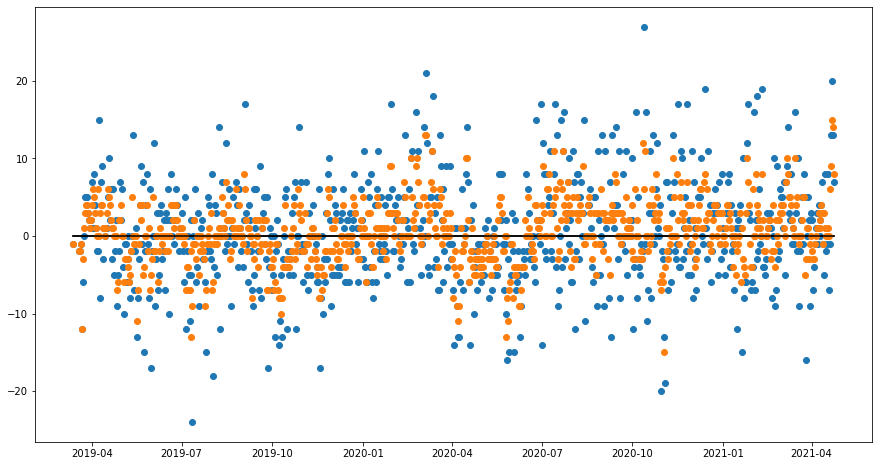

In [269]:
df = DF_CLEAN
df_resched = get_df_rescheduled(df)

df_count = get_df_count(df)
df_recount = get_df_count(df_resched)

plt.figure(figsize=(15,8))
plot_imb(df_count)
plot_imb(df_recount)

<AxesSubplot:xlabel='Imbalance', ylabel='Count'>

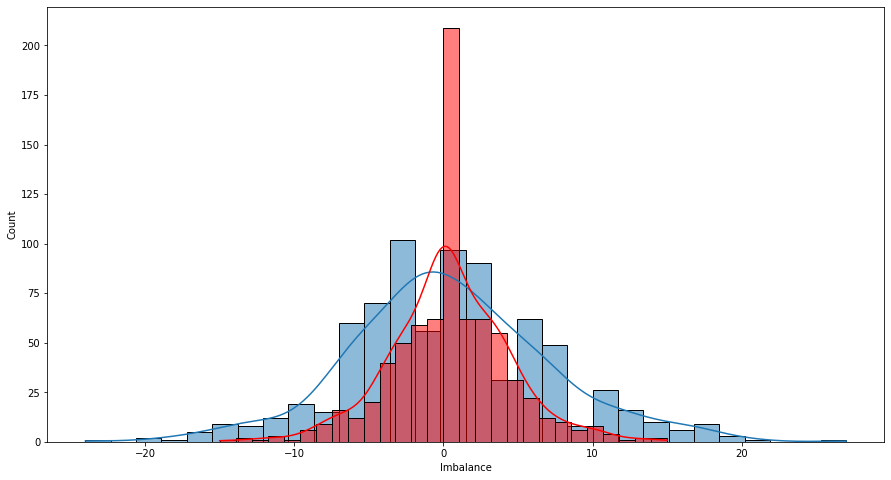

In [270]:
plt.figure(figsize=(15,8))
sns.histplot(data=df_count,x="Imbalance",kde=True)
sns.histplot(data=df_recount,x="Imbalance",color="red",kde=True)

## Our Strategy: Local Average

Idea:

```
for day in all_days:
    k_days_stack = imbalance_table[day:day+k]
    # pick out the next sequence of k days, including today. This will be our stack
    # (e.g if k=3, we pick out today, tomorrow and the day after tomorrow)

    # Now we balance locally within the stack.
    # Since we cannot just move around the imb anywhere we want, because of the dependencies involved, 
    # we will gradually balance each element in the stack (i.e make the imb level ~= stack_avg) 
    # by transferring the imb to the next day and pop the element from the stack
    
    for stack_day in k_days_stack:
        k_day_avg = k_next_days.avg
        #take the average imbalance of the elements remaining in the stack
        day_st = k.pop()
        # pop the day at top of the stack
        num_orders = k_day_avg - day_st.imb
        cand_orders = get_cand_orders(day_st,num_orders)
        
        #
        # Insert code that  move num_orders from today to the next date
        #
        
```

### Local Average: A Demo

In [271]:
random.seed(10)

# Not the real rescheduling algorithm, but can illustrate how the idea behind it works!
def local_k_average_demo(org_list,k=2,randomized=False,verbose=False):
    new_list = np.array(org_list)
    for i in range(len(new_list)-(k-1)):
        if verbose: print('\nIteration',i,new_list,"sum =",new_list.sum())
            
        for j in range(i,i+k):
            avg = int(np.average(new_list[j:i+k]))
            num_orders = avg - new_list[j]
            if not randomized:
                actual_orders = num_orders
            elif randomized:
                if num_orders == 0: actual_orders = 0 # Avoid dividing by zero problem
                else: actual_orders = int(randint(0,abs(num_orders)) * (num_orders//abs(num_orders)))
            if verbose: print('Stack ({}):'.format(j-i),new_list[j:i+k],"avg =",avg,'\tday[{}] -[{}/{} ords]-> day[{}]'.format(j,actual_orders,num_orders,j+1))
            
            new_list[j] += actual_orders
            if j+1 < len(new_list): new_list[j+1] -= actual_orders
        if verbose: print('Result Stack: ',new_list[i:i+k])
               
    if verbose: 
        print('\nOriginally:',org_list,"\n sum =",org_list.sum(),"\n std=",org_list.std())
        print('Result:(k={})'.format(k),new_list,"\n sum =",new_list.sum(),"\n std=",new_list.std())
    return list(new_list)

In [272]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,14,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df,start_date,end_date,True)
df_count

,Outbound,Inbound,Imbalance,cImbalance
2020-01-01,3,0,-3,-3
2020-01-02,6,17,11,8
2020-01-03,18,14,-4,4
2020-01-04,7,1,-6,-2
2020-01-05,7,1,-6,-8
2020-01-06,17,24,7,-1
2020-01-07,14,19,5,4
2020-01-08,15,11,-4,0
2020-01-09,12,20,8,8
2020-01-10,22,16,-6,2


In [273]:
org_list = np.array(df_count["Imbalance"])
new_list_2 = local_k_average_demo(org_list,k=3,verbose=True)
# new_list_2 = local_k_average_demo(org_list,k=4,verbose=True)
# new_list_2 = local_k_average_demo(org_list,k=5,verbose=True)
# new_list_2 = local_k_average_demo(org_list,k=6,verbose=True)
# new_list_2 = local_k_average_demo(org_list,k=7,verbose=True)
# new_list_2 = local_k_average_demo(org_list,k=7,verbose=True)
print()
print(np.array(org_list).std())
print(np.array(new_list_2).std())


Iteration 0 [-3 11 -4 -6 -6  7  5 -4  8 -6 -8 -2  4 -6] sum = -10
Stack (0): [-3 11 -4] avg = 1 	day[0] -[4/4 ords]-> day[1]
Stack (1): [ 7 -4] avg = 1 	day[1] -[-6/-6 ords]-> day[2]
Stack (2): [2] avg = 2 	day[2] -[0/0 ords]-> day[3]
Result Stack:  [1 1 2]

Iteration 1 [ 1  1  2 -6 -6  7  5 -4  8 -6 -8 -2  4 -6] sum = -10
Stack (0): [ 1  2 -6] avg = -1 	day[1] -[-2/-2 ords]-> day[2]
Stack (1): [ 4 -6] avg = -1 	day[2] -[-5/-5 ords]-> day[3]
Stack (2): [-1] avg = -1 	day[3] -[0/0 ords]-> day[4]
Result Stack:  [-1 -1 -1]

Iteration 2 [ 1 -1 -1 -1 -6  7  5 -4  8 -6 -8 -2  4 -6] sum = -10
Stack (0): [-1 -1 -6] avg = -2 	day[2] -[-1/-1 ords]-> day[3]
Stack (1): [ 0 -6] avg = -3 	day[3] -[-3/-3 ords]-> day[4]
Stack (2): [-3] avg = -3 	day[4] -[0/0 ords]-> day[5]
Result Stack:  [-2 -3 -3]

Iteration 3 [ 1 -1 -2 -3 -3  7  5 -4  8 -6 -8 -2  4 -6] sum = -10
Stack (0): [-3 -3  7] avg = 0 	day[3] -[3/3 ords]-> day[4]
Stack (1): [-6  7] avg = 0 	day[4] -[6/6 ords]-> day[5]
Stack (2): [1] avg = 1 

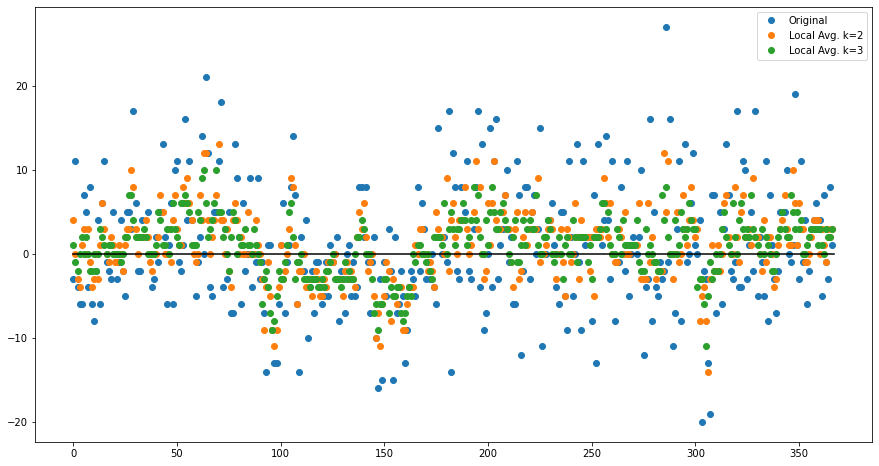

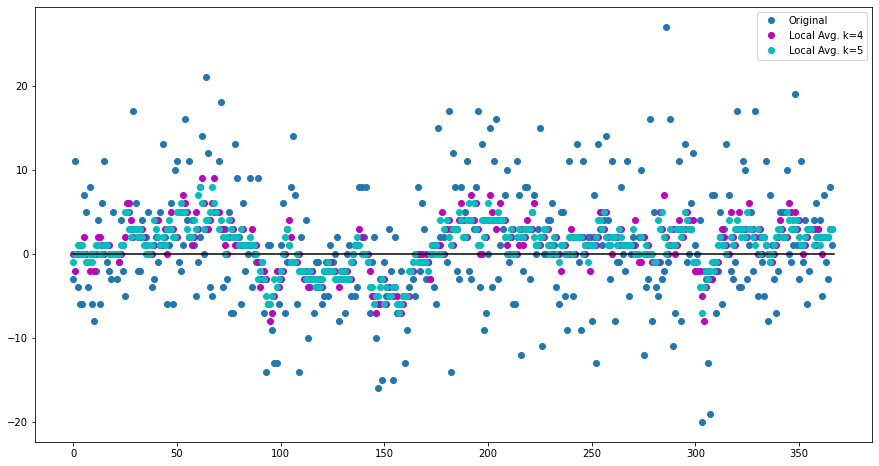

In [274]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2021,1,1,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df,start_date,end_date,True)
org_list = np.array(df_count["Imbalance"])
new_list_2 = local_k_average_demo(org_list,k=2,verbose=False)
new_list_3 = local_k_average_demo(org_list,k=3,verbose=False)
new_list_4 = local_k_average_demo(org_list,k=4,verbose=False)
new_list_5 = local_k_average_demo(org_list,k=5,verbose=False)
new_list_7 = local_k_average_demo(org_list,k=7,verbose=False)
new_list_14 = local_k_average_demo(org_list,k=14,verbose=False)
new_list_28 = local_k_average_demo(org_list,k=28,verbose=False)
new_list_50 = local_k_average_demo(org_list,k=50,verbose=False)

plt.figure(figsize=(15,8))
plt.plot(org_list,'o',label='Original',linewidth=2)
plt.plot(new_list_2,'o',label='Local Avg. k=2',linewidth=2)
plt.plot(new_list_3,'o',label='Local Avg. k=3',linewidth=2)
plt.plot([0,len(org_list)],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(org_list,'o',label='Original',linewidth=2)
plt.plot(new_list_4,'mo',label='Local Avg. k=4',linewidth=2)
plt.plot(new_list_5,'co',label='Local Avg. k=5',linewidth=2)
plt.plot([0,len(org_list)],[0,0],'k-')
plt.legend()
plt.show()

# plt.figure(figsize=(15,8))
# plt.plot(org_list,'o',label='Original',linewidth=2)
# plt.plot(new_list_7,'o',label='Local Avg. k=7',linewidth=2)
# plt.plot(new_list_14,'o',label='Local Avg. k=14',linewidth=2)
# plt.plot([0,len(org_list)],[0,0],'k-')
# plt.legend()
# plt.show()

# plt.figure(figsize=(15,8))
# plt.plot(org_list,'o',label='Original',linewidth=2)
# plt.plot(new_list_28,'mo',label='Local Avg. k=28',linewidth=2)
# plt.plot(new_list_50,'co',label='Local Avg. k=50',linewidth=2)
# plt.plot([0,len(org_list)],[0,0],'k-')
# plt.legend()
# plt.show()

In [275]:
# Monte Carlo?!

In [276]:
org_list = np.array(df_count["Imbalance"].head(10))
new_list_3 = local_k_average_demo(org_list,k=5,randomized=False,verbose=False)

## How to balance any two days?

### Helper function: Move order

In [ ]:
# Get all orders from day1 that *can be moved* to day2
def get_df_movable_only(df,col,day):
    mov = [] 
    for index in df.index:
        if (movable(df,col,index,day)):
            mov.append(index)
    return df.loc[mov]

# Can we move the Start/Completion Date of the item at index to this day?
# Condition being, the start date can not be too late compared to the original schedule, or later than the completion date)
# Condition being, the completion date can not be too early or too late compared to the original schedule 
# (see get_bound_dates() for more )
def movable(df,col,index,day):
    e_start,l_start,e_compl,l_compl = get_bound_dates(index).values()
    compl_date = df.loc[index,"Completion Date"]
    if col == 'Start Date': return day <= l_start and day <= compl_date #or day >= e_start
    elif col == 'Completion Date': return day >= e_compl and day <= l_compl
    

In [ ]:
# Resume here

In [814]:
df = DF_CLEAN
df1 = get_df_similar_orders(df,5523)
max(df1["Completion Date"]-df1["Start Date"])

Timedelta('15 days 00:00:00')

Idea:
```
How to sort orders to be moved to day2 (i.e. determine which order to pick first): 
    if col == Start Date and day1 > day2
    # If we are moving start date back,we want to prioritize shortest duration first
        orders.sortby("Completion Date", ascending)
    elif col == Start Date and day1 > day2
    # If we are moving start date forward,we want to prioritize longest duration first
        orders.sortby("Completion Date", descending)
        
    if col == Completion Date and day1 > day2
    # If we are moving the completion date back, we want to prioritize doing so with the one 
    # with the longest duration first
        orders.sortby("Completion Date", descending)
    # If we are moving the completion date forward, we want to prioritize the shortest duration first 
        orders.sortby("Completion Date", descending)

```

In [806]:
# Try to move a number of orders that starts on day1 to day2, or that completes on day1 to day2
# Return the modified the df, and the ACTUAL number of orders moved.
# This is because in reality, constraints apply and many times there are not
# enough available orders to satisfy the request
def try_move_orders(df,col,day1,day2,num_orders=None,verbose=False):
    df1 = df.copy()
    df_all_col = get_df_day(df1,day1,col)
    df_movable_only = get_df_movable_only(df_all_col,col,day2) # Get ALL orders from day1 that *can be moved* to day2
    
    if col == "Start Date":
        if day2 > day1:
        # If we are moving the Start date forward
            # Pick furthest completion dates first
            df_movable_only.sort_values(by="Completion Date",ascending=False,inplace=True) 
        elif day1 > day2:
        # If we are moving the Start date back
            # Pick nearest completion dates first
            df_movable_only.sort_values(by="Completion Date",ascending=True,inplace=True) 
    elif col == "Completion Date":
        if day2 > day1:
        # If we are moving the Completion date forward
            # Pick nearest start dates first
            df_movable_only.sort_values(by="Start Date",ascending=True,inplace=True) 
        elif day1 > day2:
        # If we are moving the Completion date back
            # Pick furthest start dates first
            df_movable_only.sort_values(by="Start Date",ascending=False,inplace=True) 

    if num_orders == None or num_orders < 0: 
        num_orders = len(df_all_col)
    df_orders = df_movable_only[:int(num_orders)] # Get just enough requested orders from day1 that can be moved to day2
    df_unmoved = df_all_col.drop(df_orders.index)
    
    for index in df_orders.index:
        assert(df1.loc[index,col] == day1)
        df1 = move(df1,index,day2,col) # Finally move such orders to day2
        
    if verbose: 
        print("Moved:\n",df_orders.loc[:,["Start Date","Completion Date"]])
        print("Unmoved:\n",df_unmoved.loc[:,["Start Date","Completion Date"]])

        print("- Moved {}/{} requested {}s from Day {} to Day {}".format(len(df_orders),num_orders,col,day1,day2))
        print(get_df_count(df1).loc[[day1,day2]])
    return df1, len(df_orders)

In [807]:
#Demo try_move_orders
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,14,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df)
print(df_count)

day1 = pd.Timestamp(2020,1,9,0)
day2 = pd.Timestamp(2020,1,7,0)

df1,a = try_move_orders(df,"Start Date",day1,day2,5,verbose=True)

            Outbound  Inbound  Imbalance  cImbalance
2019-12-30         1        0         -1          -1
2020-01-01         3        0         -3          -4
2020-01-02         6       17         11           7
2020-01-03        18       14         -4           3
2020-01-04         7        1         -6          -3
2020-01-05         7        1         -6          -9
2020-01-06        17       24          7          -2
2020-01-07        14       19          5           3
2020-01-08        15       11         -4          -1
2020-01-09        12       20          8           7
2020-01-10        22       16         -6           1
2020-01-11         9        1         -8          -7
2020-01-12         5        3         -2          -9
2020-01-13        15       19          4          -5
2020-01-14        17       11         -6         -11
2020-01-15         0        1          1         -10
Moved:
       Start Date Completion Date
10754 2020-01-09      2020-01-09
17501 2020-01-09      202

### The main balance() method

Idea:

```
bal_val: The target balance value we want day1 to achieve
        By default, we will set it as the mean of day1 and day2. But we can change to any target balance value
d_bal = bal_val - day1.imb (the amount of change in the imbalance we need to achieve)
    
if d_bal > 0:
# If we need to reduce outbound traffic/ increase inbound traffic for today

    if (day1.in >= day2.in and day1.out >= day2.out): 
    # If traffic is heavier today, we prioritize reducing outbound traffic
        #
        # We try to defer as many outbound orders to tomorrow as possible
        # If it's not enough then we make up by taking in tomorrow's inbound orders
        #

    elif (day1.in <= day2.in and day1.out <= day2.out): 
    # If traffic is less today, we prioritize increasing inbound traffic 
        #
        # We try to take in as many inbound orders from tomorrow as possible
        # If it's not enough then we make up by deferring the outbound order til tomorrow
        #

    else: 
    # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out
        #
        # We try achieve 1/2 of d_bal by taking in tomorrow inbound orders
        # Then try achieve the rest of d_bal by deferring outbound orders 
        # Go back to step 1 and try to take in more tomorrow inbound orders just in case d_bal is not achieved 
        #

elif d_bal < 0:  
# If we need to reduce incoming traffic/ increase outbound traffic for today

    if (day1.in >= day2.in and day1.out >= day2.out): 
    # If traffic is heavier today, we prioritize reducing inbound traffic
        #
        # We try to defer as many inbound orders to tomorrow as possible
        # If it's not enough then we make up by taking in the outbound order from tomorrow
        #

    elif (day1.in <= day2.in and day1.out <= day2.out): 
    # If traffic is less today, we prioritize increasing outbound traffic 
        #
        # We try to take in as many outbound orders from tomorrow as possible
        # If it's not enough then we make up by deferring some inbound truck to tomorrow
        #

    else: 
    # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out 
        #
        # We try achieve 1/2 of d_bal by deferring inbound orders to tomorrow
        # Then try achieve the rest of d_bal by taking in tomorrow outbound orders 
        # Go back to step 1 and try to defer more inbound orders to tomorrow just in case d_bal is not achieved 
        #

```

In [497]:
# Attempt to move orders between day1 and day2 to achieve a certain balance value
# By default, it would use the mean imbalance level of both days as the goal
def balance(df,day1,day2,bal_val=None,verbose=False):
    df1 = df.copy()
    df_count = get_df_count(df1,day1,day2,fill_missing=True)
    
    if verbose: 
        print("\nDays: {} - {}".format(day1,day2))
        print("Before:\n",df_count.loc[[day1,day2]])
    
    if bal_val == None: bal_val = int(np.average(df_count.loc[[day1,day2],"Imbalance"]))
    out1,in1 = df_count.loc[day1,["Outbound","Inbound"]]
    out2,in2 = df_count.loc[day2,["Outbound","Inbound"]]
    d_bal = bal_val - df_count.loc[day1,"Imbalance"]
    d_out,d_in1,d_in2= 0,0,0
    
    if d_bal > 0:
        if (in1 >= in2 and out1 >= out2):
        # If traffic is heavier today, we prioritize reducing outbound traffic
            # We try to defer as many outbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in tomorrow's inbound orders
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-d_out,verbose) 
         
        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing inbound traffic 
            # We try to take in as many inbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring the outbound order til tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 

        else:
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out
            # We try achieve 1/2 of d_bal by taking in tomorrow inbound orders
            # Then try achieve the rest of d_bal by deferring outbound orders 
            # Go back to step 1 and try to take in more tomorrow inbound orders just in case d_bal is not achieved  
            df1,d_in1 = try_move_orders(df1,"Completion Date",day2,day1,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day1,day2,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day2,day1,d_bal-(d_in1+d_out),verbose) 

    elif d_bal < 0:  # If we need to reduce incoming traffic/ increase outbound traffic
        d_bal = abs(d_bal)
        if (in1 >= in2 and out1 >= out2): 
        # If traffic is heavier today, we prioritize reducing inbound traffic
            # We try to defer as many inbound orders to tomorrow as possible
            # If it's not enough then we make up by taking in the outbound order from tomorrow
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 

        elif (in1 <= in2 and out1 <= out2): 
        # If traffic is less today, we prioritize increasing outbound traffic 
            # We try to take in as many outbound orders from tomorrow as possible
            # If it's not enough then we make up by deferring some inbound truck to tomorrow
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal,verbose) 
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-d_out,verbose) 

        else: 
        # If inbound and outbound traffic comparison is mixed, we pick half each type to even everything out 
            # We try achieve 1/2 of d_bal by deferring inbound orders to tomorrow
            # Then try achieve the rest of d_bal by taking in tomorrow outbound orders 
            # Go back to step 1 and try to defer more inbound orders to tomorrow just in case d_bal is not achieved
            df1,d_in1 = try_move_orders(df1,"Completion Date",day1,day2,d_bal//2,verbose) 
            df1,d_out = try_move_orders(df1,"Start Date",day2,day1,d_bal-d_in1,verbose) 
            df1,d_in2 = try_move_orders(df1,"Completion Date",day1,day2,d_bal-(d_in1+d_out),verbose) 
            
        d_bal *= -1
        d_in1 *= -1
        d_in2 *= -1
        d_out*=-1
    
    d_out*=-1
    
    df_count = get_df_count(df1,day1,day2,fill_missing=True)
    if verbose:
        print("d_bal =",d_bal,": d_out =", d_out,"d_in =",d_in1+d_in2,"(bal_val =",bal_val,")")
        print("After:\n",df_count.loc[[day1,day2]],'\n')

    return df1
        

In [498]:
# Demo balance()
date = pd.Timestamp(2020,12,24,0)
df = get_df_span(DF_CLEAN,date,date+14*DAYS_1)
df_count = get_df_count(df)
print(df_count)
day1 = df_count.index[-4]
day2 = df_count.index[-1]

# out1,in1 = df_count.loc[day1,["Inbound","Outbound"]]
# out1,in1
df1 = balance(df,day1,day2,verbose=True)

            Outbound  Inbound  Imbalance  cImbalance
2020-12-22         2        0         -2          -2
2020-12-24        10       16          6           4
2020-12-25         3        6          3           7
2020-12-26         7       11          4          11
2020-12-27        11        6         -5           6
2020-12-28        13       20          7          13
2020-12-29        18       17         -1          12
2020-12-30        21       18         -3           9
2020-12-31        15       23          8          17
2021-01-01         1        2          1          18
2021-01-02        12       10         -2          16
2021-01-03         8        3         -5          11
2021-01-04        20       23          3          14
2021-01-05        23       26          3          17
2021-01-06        18       25          7          24
2021-01-07        15       23          8          32

Days: 2021-01-04 00:00:00 - 2021-01-07 00:00:00
Before:
             Outbound  Inbound  Imbalance 

## Local k Average with proper balancing

Idea:
    For  every group of k days, each and every day will balance itself based on the average of the k-day forecast.

In [519]:
def local_k_average(df,k=2,verbose=False):
    df_resched = df.copy()
    df_count = get_df_count(df_resched,fill_missing=True)
    dates = df_count.index
    num_days = len(dates)
    for i in range(num_days):
        k = int(min(num_days-i,k)) # Address the last k-1 problem. (More at the end) 
        local_queue = list(range(i,i+k))
        while (len(local_queue)>=2):
            day1 = dates[local_queue[0]]
            day2 = dates[local_queue[1]]
            last = dates[local_queue[-1]]
            df_count = get_df_count(df_resched,day1,last,fill_missing=True)
            bal_val = int(np.average(df_count.loc[day1:last,"Imbalance"]))
            df_resched = balance(df_resched,day1,day2,bal_val,verbose)
            local_queue.pop(0)
    return df_resched

In [707]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,2,1,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df,fill_missing=False)

df1 = local_k_average(df,k=4,verbose=False)
df_recount = get_df_count(df1,fill_missing=False)
compare_df_count([df,df1])

,Outbound,Inbound,Imbalance,cImbalance,Outbound,Inbound,Imbalance,cImbalance
2019-12-30,1,0,-1,-1,0,0,0,0
2019-12-31,0,0,0,-1,0,0,0,0
2020-01-01,3,0,-3,-4,7,7,0,0
2020-01-02,6,17,11,7,11,9,-2,-2
2020-01-03,18,14,-4,3,8,8,0,-2
2020-01-04,7,1,-6,-3,7,8,1,-1
2020-01-05,7,1,-6,-9,10,10,0,-1
2020-01-06,17,24,7,-2,14,16,2,1
2020-01-07,14,19,5,3,14,14,0,1
2020-01-08,15,11,-4,-1,16,14,-2,-1


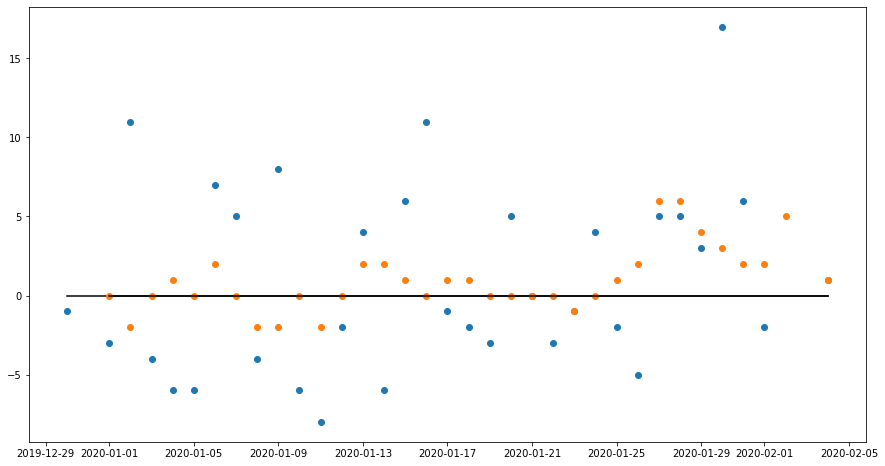

In [708]:
plt.figure(figsize=(15,8))
plot_imb(df_count)
plot_imb(df_recount)

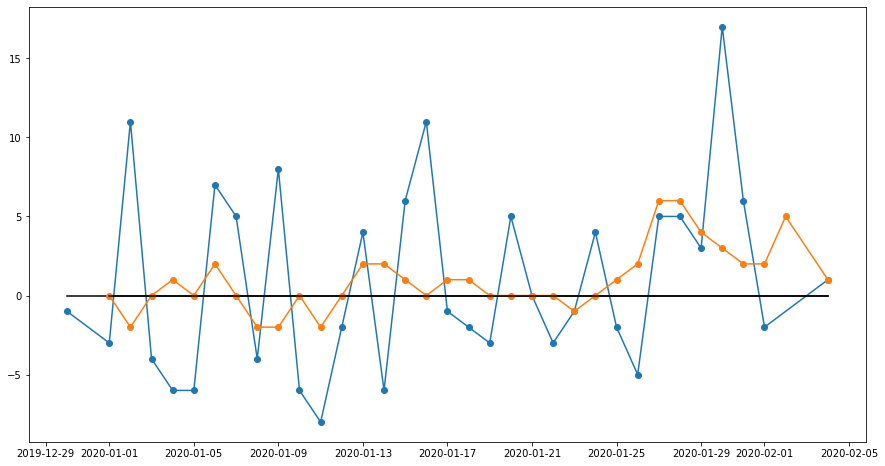

In [709]:
plt.figure(figsize=(15,8))
plot_imb(df_count.tail(100),'-o')
plot_imb(df_recount.tail(100),'-o')

#### Traffic Count Distribution

<AxesSubplot:title={'center':'Traffic Count Distribution'}, xlabel='Outbound', ylabel='Inbound'>

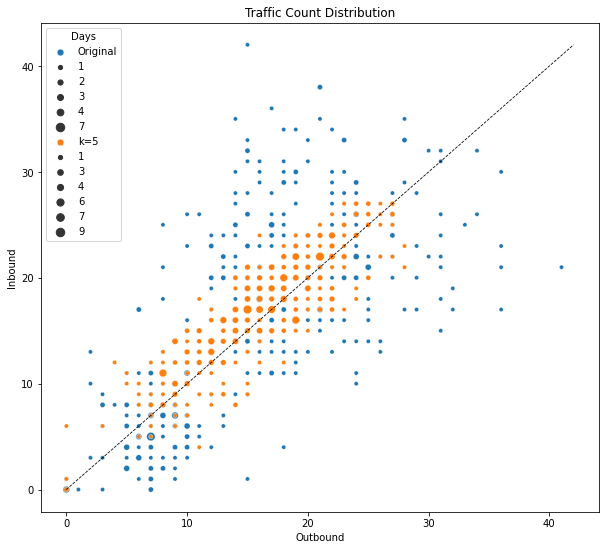

In [604]:
df1 = pd.DataFrame(df_count.value_counts(["Outbound","Inbound"])).rename(columns={0:"Days"})
df2 = pd.DataFrame(df_recount.value_counts(["Outbound","Inbound"])).rename(columns={0:"Days"})

plt.figure(figsize=(10,9))
max_val = df_count.loc[:,["Inbound","Outbound"]].max().max()
plt.title("Traffic Count Distribution")
plt.plot([0,max_val],[0,max_val],'k--',linewidth=.8)
sns.scatterplot(data=df1, x="Outbound", y="Inbound", size="Days",label="Original")
sns.scatterplot(data=df2, x="Outbound", y="Inbound", size="Days",label="k=5")

### Algorithm Performance

In [653]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,1,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_time = pd.DataFrame(index=[2,3,4,5,6,7,10,14])

for k in df_time.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_average(df,k,verbose=False)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/2020/"+"k_"+str(k))
    df_time.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time.loc[k,"Time (s)"]))
    
    
df_time

k = 2 : 2.142759
k = 3 : 3.179909
k = 4 : 4.893884
k = 5 : 6.208476
k = 6 : 7.748071
k = 7 : 9.196323
k = 10 : 13.862939
k = 14 : 19.256375


,Time (s)
2,2.142759
3,3.179909
4,4.893884
5,6.208476
6,7.748071
7,9.196323
10,13.862939
14,19.256375


In [648]:
start_date = pd.Timestamp(2020,1,1,0)
end_date = pd.Timestamp(2020,12,31,0)
df = get_df_span(DF_CLEAN,start_date,end_date)
df_time = pd.DataFrame(index=[2,3,4,5,6,7,10,14])

for k in df_time.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_average(df,k,verbose=False)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/2020/"+"k_"+str(k))
    df_time.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time.loc[k,"Time (s)"]))
    
    
df_time

k = 2 : 32.581489
k = 3 : 60.806769
k = 4 : 94.095548
k = 5 : 130.904195
k = 6 : 155.882533
k = 7 : 172.769656
k = 10 : 262.976409
k = 14 : 370.915650


,Time (s)
2,32.581489
3,60.806769
4,94.095548
5,130.904195
6,155.882533
7,172.769656
10,262.976409
14,370.915650


In [646]:
df = pd.read_csv("dfs/k_14")
df

,Unnamed: 0,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
0,15,Standard,DRY,PQ2OTT,PQ2MON,2020-01-01,2020-01-03
1,26,Standard,DRY,PQ2OTT,PQ2S,2020-01-13,2020-01-15
2,46,Standard,DRY,PQ2S,USMWMO,2020-01-10,2020-01-13
3,58,Standard,DRY,USMNMI,PQ2S,2020-01-03,2020-01-07
4,59,Standard,DRY,USMNMI,PQ2S,2020-01-10,2020-01-15
...,...,...,...,...,...,...,...
346,23270,Standard,DRY,PQ2MON,USSCTN,2020-01-02,2020-01-08
347,23271,Standard,DRY,PQ2MON,USSCTN,2020-01-09,2020-01-14
348,23272,Standard,DRY,PQ2MON,USSCTN,2020-01-10,2020-01-14
349,23273,Standard,DRY,PQ2MON,USSCTN,2020-01-13,2020-01-21


In [647]:
df_count = get_df_count(df)
df_count

,Outbound,Inbound,Imbalance,cImbalance
2020-01-01,4,4,0,0
2020-01-02,13,13,0,0
2020-01-03,11,11,0,0
2020-01-04,5,5,0,0
2020-01-05,11,11,0,0
2020-01-06,14,14,0,0
2020-01-07,15,15,0,0
2020-01-08,14,14,0,0
2020-01-09,12,12,0,0
2020-01-10,14,14,0,0


#### Test out the running time on the whole dataset

In [ ]:
# start_date = pd.Timestamp(2020,1,1,0)
# end_date = pd.Timestamp(2020,12,31,0)
# df = get_df_span(DF_CLEAN,start_date,end_date)

df = DF_CLEAN
df_time = pd.DataFrame(index=[2,3,5,7,10,15,30,60])

for k in df_time.index:
    #    <<---- Begin timer ---->>
    start_time = time.time()
    #    <<--- Begin execution ->>
    
    df_resched = local_k_average(df,k,verbose=False)
    
    #    <<--- End execution --->>
    end_time = time.time()
    #    <<----- End timer ----->>
    
    # Post execution
    df_resched.to_csv("dfs/all_time/"+"k_"+str(k))
    df_time.loc[k,"Time (s)"] = end_time-start_time
    print("k = {} : {:.6f}".format(k,df_time.loc[k,"Time (s)"]))
    
df_time.to_csv("dfs/all_time/df_time")   
df_time

In [657]:
# df_time1 = pd.read_csv("dfs/all_time/df_time")
# df_time1

In [528]:
# Schedule integrity constraints and assumptions

In [750]:
def read_csv(filepath):
    df = pd.read_csv(filepath).rename(columns={"Unnamed: 0":"index"}).set_index("index")
    df["Start Date"] = pd.to_datetime(df["Start Date"])
    df["Completion Date"] = pd.to_datetime(df["Completion Date"])
    return df
    
read_csv("dfs/all_time/k_2")

,Priority,Requested Trailer Class,Shipper Region3,Consignee Region3,Start Date,Completion Date
index,,,,,,
0,Standard,DRY,ON2TOR,PQ2S,2019-04-16,2019-04-18
1,Standard,DRY,ON2TOR,PQ2S,2019-05-07,2019-05-09
2,Standard,DRY,ON2TOR,PQ2S,2019-06-07,2019-06-10
3,Standard,DRY,ON2TOR,PQ2S,2019-07-09,2019-07-11
4,Standard,DRY,PQ2MON,USMWIA,2020-02-26,2020-03-02
...,...,...,...,...,...,...
23864,Standard,DRY,PQ2MON,BC2VAN,2020-06-18,2020-06-22
23865,Standard,REEFER,PQ2MON,ABNEDM,2020-02-12,2020-02-18
23866,Standard,REEFER,PQ2MON,ABNEDM,2020-02-13,2020-02-20


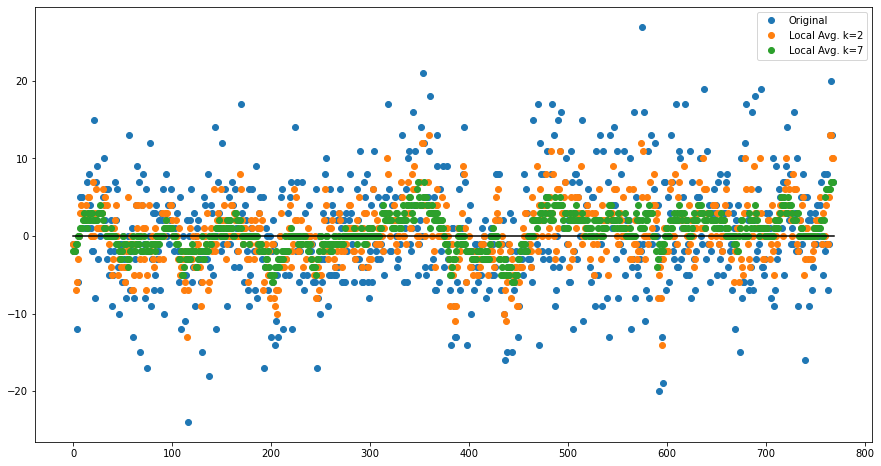

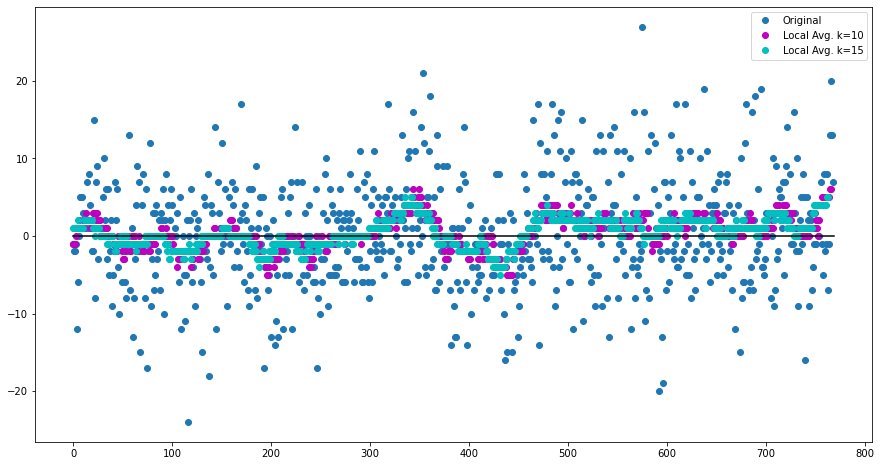

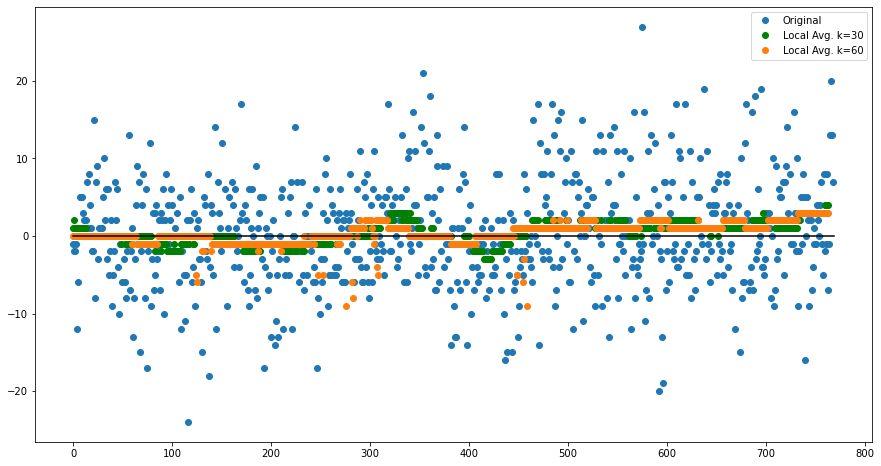

In [751]:
df = DF_CLEAN
df_2 = read_csv("dfs/all_time/k_2")
df_7 = read_csv("dfs/all_time/k_7")
df_10 = read_csv("dfs/all_time/k_10")
df_15 = read_csv("dfs/all_time/k_15")
df_30 = read_csv("dfs/all_time/k_30")
df_60 = read_csv("dfs/all_time/k_60")

df_count = get_df_count(DF_CLEAN)
df_count_2 = get_df_count(df_2)
df_count_7 = get_df_count(df_7)
df_count_10 = get_df_count(df_10)
df_count_15 = get_df_count(df_15)
df_count_30 = get_df_count(df_30)
df_count_60 = get_df_count(df_60)

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'o',label='Original',linewidth=2)
plt.plot(list(df_count_2["Imbalance"]),'o',label='Local Avg. k=2',linewidth=2)
plt.plot(list(df_count_7["Imbalance"]),'o',label='Local Avg. k=7',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'o',label='Original',linewidth=2)
plt.plot(list(df_count_10["Imbalance"]),'mo',label='Local Avg. k=10',linewidth=2)
plt.plot(list(df_count_15["Imbalance"]),'co',label='Local Avg. k=15',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

plt.figure(figsize=(15,8))
plt.plot(list(df_count["Imbalance"]),'o',label='Original',linewidth=2)
plt.plot(list(df_count_30["Imbalance"]),'go',label='Local Avg. k=30',linewidth=2)
plt.plot(list(df_count_60["Imbalance"]),'o',label='Local Avg. k=60',linewidth=2)
plt.plot([0,len(df_count)],[0,0],'k-')
plt.legend()
plt.show()

In [719]:
print(df_count_2["Imbalance"].std(),get_ci(df_count_2["Imbalance"]))
print(df_count_7["Imbalance"].std(),get_ci(df_count_7["Imbalance"]))
print(df_count_10["Imbalance"].std(),get_ci(df_count_10["Imbalance"]))
print(df_count_15["Imbalance"].std(),get_ci(df_count_15["Imbalance"]))
print(df_count_30["Imbalance"].std(),get_ci(df_count_30["Imbalance"]))
print(df_count_60["Imbalance"].std(),get_ci(df_count_60["Imbalance"]))

3.9390421174606747 (-3.5484171174606747, 4.329667117460675)
2.31273173020927 (-1.9174131346305963, 2.7080503257879434)
2.0577528931178213 (-1.6614034798192554, 2.454102306416387)
1.7915765658684975 (-1.3936708067061938, 2.1894823250308013)
1.4007284424008826 (-1.002822683238579, 1.7986342015631862)
1.3960422663571672 (-0.9981365071948636, 1.7939480255194709)


In [778]:
print(get_df_sched_diff(df,df_2,drop_na=False).value_counts().sort_index(),'\n')
print(get_df_sched_diff(df,df_7,drop_na=False).value_counts().sort_index(),'\n')
# print(get_df_sched_diff(df,df_10,drop_na=False).value_counts().sort_index(),'\n')

Start Date  Completion Date
-1 days     0 days               550
0 days      -1 days              675
            0 days             20769
            1 days               631
1 days      0 days               403
2 days      0 days                42
3 days      0 days                 3
5 days      0 days                 1
dtype: int64 

Start Date  Completion Date
-3 days     0 days                50
-2 days     0 days               515
-1 days     -1 days                2
            0 days              1631
            1 days                 1
0 days      -1 days             2378
            0 days             15302
            1 days              1900
1 days      -1 days                1
            0 days               773
            1 days                 1
2 days      -1 days                3
            0 days               352
            1 days                 1
3 days      0 days               102
4 days      0 days                45
5 days      0 days                 9
6 da

# Demos

### The last k-1 day problem

Our algorithm only runs til len-k, so the last k-1 days will not entered the main balancing loop (even though they might still indirectly be balanced, having appeared in the queue of the previous day). The last day is really a problem though,  because it will not be guaranteed to be balanced by our algorithm at all

In [520]:
# The previous iteration of the algorithm 
def local_k_average_(df,k=2,verbose=False):
    df_resched = df.copy()
    df_count = get_df_count(df_resched,fill_missing=True)
    dates = df_count.index
    for i in range(len(dates)-k):
        local_queue = list(range(i,i+k))
        while (len(local_queue)>=2):
            day1 = dates[local_queue[0]]
            day2 = dates[local_queue[1]]
            last = dates[local_queue[-1]]
            df_count = get_df_count(df_resched,day1,last,fill_missing=True)
            bal_val = int(np.average(df_count.loc[day1:last,"Imbalance"]))
            df_resched = balance(df_resched,day1,day2,bal_val,verbose)
            local_queue.pop(0)
    return df_resched

In [518]:
start_date = pd.Timestamp(2021,1,5,0)
end_date = pd.Timestamp(2021,1,15,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df,fill_missing=True)

df1 = local_k_average_(df,k=5,verbose=False)
df_recount = get_df_count(df1,fill_missing=True)
compare_df_count([df,df1])

,Outbound,Inbound,Imbalance,cImbalance,Outbound,Inbound,Imbalance,cImbalance
2021-01-04,1,0,-1,-1,1,3,2,2
2021-01-05,23,26,3,2,21,24,3,5
2021-01-06,18,25,7,9,19,21,2,7
2021-01-07,15,23,8,17,19,20,1,8
2021-01-08,22,18,-4,13,18,18,0,8
2021-01-09,8,12,4,17,11,11,0,8
2021-01-10,9,7,-2,15,14,14,0,8
2021-01-11,22,21,-1,14,18,18,0,8
2021-01-12,22,15,-7,7,19,20,1,9
2021-01-13,23,26,3,10,23,24,1,10


After the fix, we can see the imbalance of the last day is now taken into consideration

In [517]:
start_date = pd.Timestamp(2021,1,5,0)
end_date = pd.Timestamp(2021,1,15,0)

df = get_df_span(DF_CLEAN,start_date,end_date)
df_count = get_df_count(df,fill_missing=True)

df1 = local_k_average(df,k=5,verbose=False)
df_recount = get_df_count(df1,fill_missing=True)
compare_df_count([df,df1])

,Outbound,Inbound,Imbalance,cImbalance,Outbound,Inbound,Imbalance,cImbalance
2021-01-04,1,0,-1,-1,1,3,2,2
2021-01-05,23,26,3,2,21,24,3,5
2021-01-06,18,25,7,9,19,21,2,7
2021-01-07,15,23,8,17,19,20,1,8
2021-01-08,22,18,-4,13,18,18,0,8
2021-01-09,8,12,4,17,11,11,0,8
2021-01-10,9,7,-2,15,14,14,0,8
2021-01-11,22,21,-1,14,19,18,-1,7
2021-01-12,22,15,-7,7,22,20,-2,5
2021-01-13,23,26,3,10,26,24,-2,3


## Demo for our balancing

In [100]:
def balance_demo(df,day1,day2,bal_val=None,verbose=False):
    df1 = df.copy()
    if verbose: 
        print("\nDays: {} - {}".format(day1,day2))
        print("Before:\n",df1.loc[[day1,day2]])
    
    if bal_val == None: 
        bal_val = int(np.average(df1.loc[[day1,day2],"Imbalance"]))
    in1,in2 = df1.loc[[day1,day2],"Inbound"]
    out1,out2 = df1.loc[[day1,day2],"Outbound"]
    d_bal = bal_val - df1.loc[day1,"Imbalance"] 
    d_out,d_in= 0,0


    if d_bal > 0: # If we need to add more incoming traffic/ reducing outgoing traffic
        if (in1 >= in2 and out1 >= out2): # if traffic is heavier today, we prioritize reducing outbound traffic
            d_out = move_ord_(df1,"Outbound",day1,day2,d_bal) # We defer as many outbound orders to tomorrow as possible
            d_in = move_ord_(df1,"Inbound",day2,day1,d_bal-d_out) # If it's not enough then we make up by taking in tomorrow's completion

        elif (in1 < in2 and out1 < out2): # if traffic is less today, we prioritize increasing inbound traffic 
            d_in = move_ord_(df1,"Inbound",day2,day1,d_bal) # We take in as many inbound orders from tomorrow as possible
            d_out = move_ord_(df1,"Outbound",day1,day2,d_bal-d_in) # If it's not enough then we make up by deferring the outbound order til tomorrow

        else: # else we split the order between moving the start date and completion date 
            d_in = move_ord_(df1,"Inbound",day2,day1,d_bal//2) # Try to see if we can take in some inbound order
            d_out = move_ord_(df1,"Outbound",day1,day2,d_bal-d_in) # Then try to see if we can defer the outbound orders 
            d_in += move_ord_(df1,"Inbound",day2,day1,d_bal-(d_in+d_out)) # Just in case after the first 2 steps, there's still job to be moved

    elif d_bal < 0:  # If we need to reduce incoming traffic/ increase outbound traffic
        d_bal = abs(d_bal)
        if (in1 > in2 and out1 > out2): # if traffic is heavier today, we prioritize reducing inbound traffic
            d_in = move_ord_(df1,"Inbound",day1,day2,d_bal) # We defer as many inbound orders to tomorrow as possible
            d_out = move_ord_(df1,"Outbound",day2,day1,d_bal-d_in) # If it's not enough then we make up by taking in the outbound order from tomorrow

        elif (in1 <= in2 and out1 <= out2): # if traffic is less today, we prioritize increasing outbound traffic 
            d_out = move_ord_(df1,"Outbound",day2,day1,d_bal) # We take in as many outbound orders from tomorrow as possible
            d_in = move_ord_(df1,"Inbound",day1,day2,d_bal-d_out) # If it's not enough then we make up by deferring some inbound truck to tomorrow

        else: # else we split the order between moving the start date and completion date 
            d_in = move_ord_(df1,"Inbound",day1,day2,d_bal//2) # We defer as many inbound orders to tomorrow as possible
            d_out = move_ord_(df1,"Outbound",day2,day1,d_bal-d_in) # If it's not enough then we make up by taking in the outbound order from tomorrow
            d_in += move_ord_(df1,"Inbound",day1,day2,d_bal-(d_in+d_out)) # We defer as many inbound orders to tomorrow as possible
        d_bal *= -1
        d_in *= -1

    if verbose:
        print("d_bal =",d_bal,": d_in =",d_in, "d_out =", d_out)
        print("After:\n",df1.loc[[day1,day2]],'\n')
        
    return df1

def move_ord_(df,col,fr,to,num_ord):
    actual_ord = int(min(df.loc[fr,col],num_ord))
    df.loc[fr,col] -= actual_ord
    df.loc[to,col] += actual_ord
    df.loc[fr,"Imbalance"] = df.loc[fr,"Inbound"] - df.loc[fr,"Outbound"]
    df.loc[to,"Imbalance"] = df.loc[to,"Inbound"] - df.loc[to,"Outbound"]
    return actual_ord   

In [101]:
random.seed(10)
min_val = 0
max_val = 20

df = pd.DataFrame()
df['Inbound'] = np.array([randint(min_val,max_val) for i in range(15)])
df['Outbound'] = np.array([randint(min_val,max_val) for i in range(15)])
df['Imbalance'] = df['Inbound'] - df['Outbound']
df

,Inbound,Outbound,Imbalance
0,18,10,8
1,1,2,-1
2,13,7,6
3,15,11,4
4,18,1,17
5,0,13,-13
6,6,4,2
7,14,19,-5
8,15,11,4
9,8,12,-4


In [102]:
# balance_demo(df,0,1,verbose=True)
df1 = balance_demo(df,7,8,verbose=True)
# balance_demo(df,9,10,verbose=True)
# balance_demo(df,12,13,verbose=True)
pd.concat([df,df1],axis=1)


Days: 7 - 8
Before:
    Inbound  Outbound  Imbalance
7       14        19         -5
8       15        11          4
d_bal = 5 : d_in = 2 d_out = 3
After:
    Inbound  Outbound  Imbalance
7       16        16          0
8       13        14         -1 



,Inbound,Outbound,Imbalance,Inbound,Outbound,Imbalance
0,18,10,8,18,10,8
1,1,2,-1,1,2,-1
2,13,7,6,13,7,6
3,15,11,4,15,11,4
4,18,1,17,18,1,17
5,0,13,-13,0,13,-13
6,6,4,2,6,4,2
7,14,19,-5,16,16,0
8,15,11,4,13,14,-1
9,8,12,-4,8,12,-4


In [104]:
df_count = get_df_count(DF_CLEAN)
df2 = df_count.head(15)

for i in range(len(df2.index[:-1])):
    df2 = balance_demo(df2,df2.index[i],df2.index[i+1],verbose=False)
    
pd.concat([df_count.head(15),df2],axis=1)

,Outbound,Inbound,Imbalance,cImbalance,Outbound,Inbound,Imbalance,cImbalance
2019-03-13,1,0,-1,-1,1,0,-1,-1
2019-03-19,2,0,-2,-3,2,0,-2,-3
2019-03-20,2,0,-2,-5,1,0,-1,-5
2019-03-21,1,0,-1,-6,7,0,-7,-6
2019-03-22,12,0,-12,-18,6,0,-6,-18
2019-03-23,6,0,-6,-24,5,2,-3,-24
2019-03-24,3,3,0,-24,5,5,0,-24
2019-03-25,9,14,5,-19,9,12,3,-19
2019-03-26,13,18,5,-14,13,17,4,-14
2019-03-27,15,20,5,-9,16,19,3,-9


In [590]:
## Color Palette

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'